In [268]:
import numpy as np
import matplotlib.pyplot as plt

In [269]:
# Pricing parameters
T = 1000
K_prices = 100
cost = 0
prices = np.linspace(0,1.5,K_prices)
coef = np.random.uniform(0.5,3,T)
conversion_probability = np.zeros((T,K_prices))
for i in range(T):
    prob = np.ones(K_prices)-coef[i]*prices
    conversion_probability[i]=prob*(prob>0)
# reward_sequence = conversion_probability*(prices-cost)

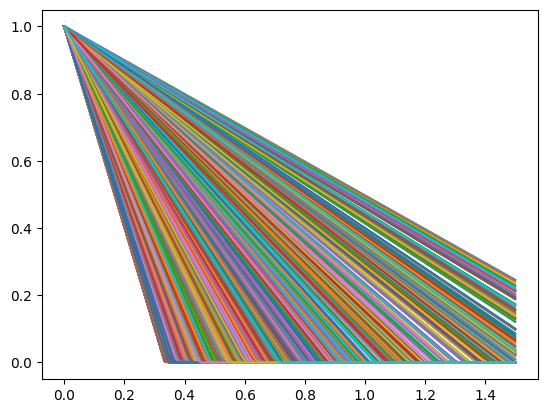

In [270]:
for i in range(T):
    plt.plot(prices,conversion_probability[i])

In [271]:
# # Princing Environment
class AdversarialExpertEnvironment:
    def __init__(self, reward_sequence):
        self.reward_sequence = reward_sequence
        self.t = 0

    def round(self): # we do not need to receive a specific arm
        r_t = self.reward_sequence[self.t, :] ## we return the whole loss vector
        self.t+=1
        return r_t

In [272]:
# Pricing Agent
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, r_t):
        self.weights *= np.exp(-self.learning_rate*(1-r_t))
        self.t += 1

In [273]:
# Auctions parameters
n_users = 50       # number of users each day
K_bids = 80        # number of available bids
n_advertisers = 4  # number of advertisers other than us
B = 5              # budget
rho = B/n_users    # budget per round
n_slots = 3        # number of slots

# non-trivial scenario: competitors sample bids from a uniform with range varying over time
pattern = lambda t: 0.8-np.abs(np.sin(5*t/n_users)/2)
other_bids = np.array([np.random.uniform(0.2, pattern(t), size = n_advertisers) for t in range(n_users)]).T
# I assume that competitors may have a larger budget than mine, but they may not deplete it.

# assuming all slots have the same prominence (probability of being clicked)
adv_ranking = np.sort(other_bids, axis=0)
m_t = adv_ranking[-n_slots]

available_bids = np.linspace(0,1,K_bids)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

In [274]:
# Auctions Environment
class FirstPriceAuction:
    def __init__(self, ctrs, n_slots):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
        self.n_slots = n_slots

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-self.n_slots:]
        return winner, adv_values

    def get_payments_per_click(self, winners, values, bids):
        payment = values[winners]/self.ctrs[winners]
        return payment.round(2)
    
    def round(self, bids):
        winners, values = self.get_winners(bids)
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [275]:
# Auctions Agent

# Regret minimizer for multiplicative pacing
class RegretMinimizer_Hedge:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

# Multiplicative pacing agent
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = RegretMinimizer_Hedge(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

In [277]:
# Interaction
pricing_learning_rate = np.sqrt(np.log(K_prices)/T) # we set the learning rate as prescribed by the theory
pricingAgent = HedgeAgent(K_prices,pricing_learning_rate)
pricingEnv = AdversarialExpertEnvironment(conversion_probability)

auctionsEnv = FirstPriceAuction(np.ones(n_advertisers+1), n_slots) # assuming all advertisers have the same CTR=1 ie their ads are clicked with probability 1
auctions_learning_rate = 1/np.sqrt(n_users)

agent_reward = np.array([])
expected_agent_reward = np.array([])

reward_sequence = np.zeros((T,K_prices))
counter = 0
for t in range(T):
    a_t = pricingAgent.pull_arm()
    p=prices[a_t]
    buy_probabilities = pricingEnv.round()
    utility_sequence=[]
    # TODO: change n_users each day ?
    auctionsAgent = FFMultiplicativePacingAgent(available_bids, p, B, n_users, auctions_learning_rate)
    for u in range(n_users):
        my_bid = auctionsAgent.bid()
        if my_bid>p:
            counter+=1
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auctionsEnv.round(bids)
        my_win = int(0 in winners)
        f_t, c_t = (p-my_bid)*my_win, my_bid*my_win
        auctionsAgent.update(f_t, c_t, m_t[u])
        utility_sequence.append(f_t)
    mean_utility=np.mean(utility_sequence)
    for a in range(K_prices):
            reward_sequence[t,a] = mean_utility*buy_probabilities[a]
    r_t=reward_sequence[t,a_t]
    pricingAgent.update(r_t)
    # logging
    agent_reward = np.append(agent_reward, r_t)
    expected_agent_reward = np.append(expected_agent_reward, np.dot(reward_sequence[t,:], pricingAgent.x_t))


In [284]:
print(f"The auctions agent bid higher than the product price {round(100*counter/(T*n_users),2)} % of the time")

The auctions agent bid higher than the product price 6.53 % of the time


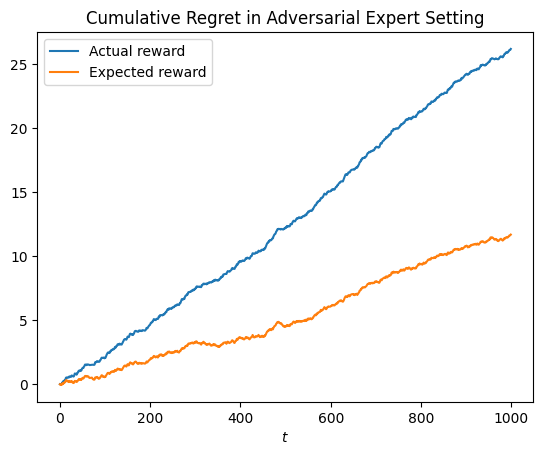

In [280]:
# Pricing performance

best_arm = np.argmax(reward_sequence.sum(axis=0))
clairvoyant_reward = reward_sequence[:, best_arm]

plt.plot(np.cumsum(clairvoyant_reward-agent_reward), label='Actual reward')
plt.plot(np.cumsum(clairvoyant_reward-expected_agent_reward), label='Expected reward')
plt.title('Cumulative Regret in Adversarial Expert Setting')
plt.xlabel('$t$')
plt.legend()
plt.show()

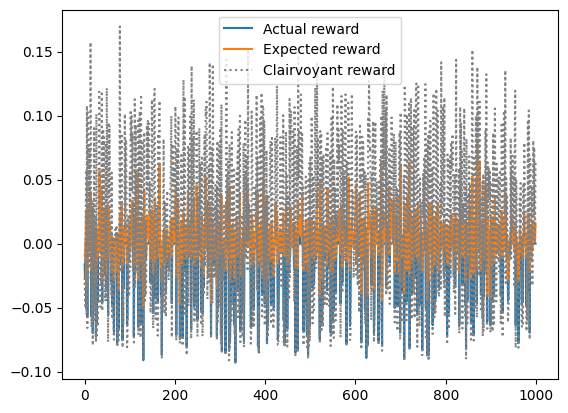

In [281]:
plt.plot(agent_reward, label='Actual reward')
plt.plot(expected_agent_reward, label='Expected reward')
plt.plot(clairvoyant_reward, label='Clairvoyant reward', linestyle=':', color='grey')
plt.legend()

reward_sequence : min=-0.09291139240506328, max=0.1695512082853855


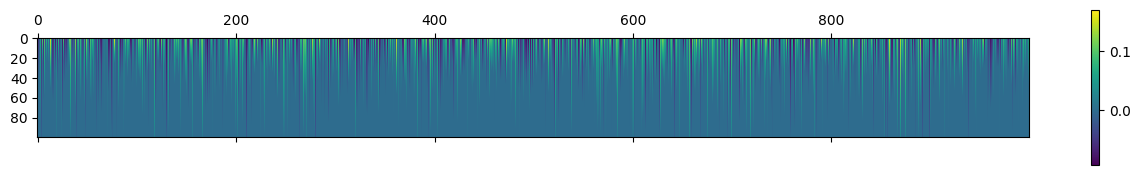

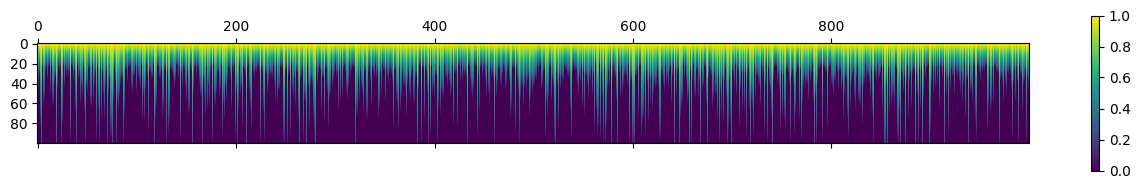

In [282]:
print(f"reward_sequence : min={reward_sequence.min()}, max={reward_sequence.max()}")
plt.matshow(reward_sequence.T)
plt.colorbar()
plt.matshow(conversion_probability.T)
plt.colorbar()